# Image Quilting

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

datadir = "./" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: ./utils.py and ./utils.py are identical (not copied).
cp: ./samples and ./samples are identical (not copied).


In [4]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture

In [150]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    i = 0
    j = 0
    width = sample.shape[0]
    height = sample.shape[1]
    image = np.zeros((out_size, out_size, 3))
    while (i+patch_size) < out_size:
        while(j+patch_size) < out_size:
            random_x = np.random.randint(width-patch_size)
            random_y = np.random.randint(height-patch_size)
            image[i:i+patch_size, j:j+patch_size] = sample[random_x:random_x+patch_size, random_y:random_y+patch_size]
            j = j + patch_size
        j = 0
        i = i + patch_size
    return image/255
            
            


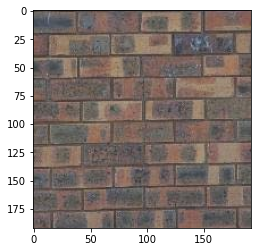

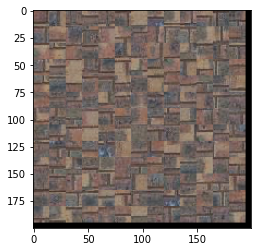

In [151]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200 
patch_size = 15 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [11]:
# # Template is the target match

def ssd_patch(target, mask, sample, patch_size):
    # RGB three layers 
    sample_0, sample_1 ,sample_2 = cv2.split(sample/225)
    template_0, template_1, template_2 = cv2.split(target/225)
    
    center = patch_size // 2
    
    ssd_0 = np.zeros(sample.shape[0:2]);
    ssd_1 = np.zeros(sample.shape[0:2]);
    ssd_2 = np.zeros(sample.shape[0:2]);
     
    ssd_0 = ((mask*template_0)**2).sum() - 2 * cv2.filter2D(sample_0, ddepth=-1, kernel = mask*template_0) + cv2.filter2D(sample_0 ** 2, ddepth=-1, kernel=mask)
    ssd_1 = ((mask*template_1)**2).sum() - 2 * cv2.filter2D(sample_1, ddepth=-1, kernel = mask*template_1) + cv2.filter2D(sample_1 ** 2, ddepth=-1, kernel=mask)
    ssd_2 = ((mask*template_2)**2).sum() - 2 * cv2.filter2D(sample_2, ddepth=-1, kernel = mask*template_2) + cv2.filter2D(sample_2 ** 2, ddepth=-1, kernel=mask)
    return ssd_0 + ssd_1 + ssd_2


In [14]:
def choose_sample(ssd, tol, patch_size):
    
    # 2d array tol in the first col and then x y position in the second and third
    smallest = np.zeros((tol, 3))
    smallest[:, 0] = 9223372036854775807
    smallest[:, 1] = 0
    smallest[:, 2] = 0
    center = patch_size // 2
    for i in range(center, ssd.shape[0]-center):
        for j in range(center, ssd.shape[1]-center):
            currMax = np.amax(smallest[:, 0])
            currMax_i = np.argmax(smallest[:, 0])
            if ssd[i, j] == 0:
                continue;
            if ssd[i, j] < currMax:
                smallest[currMax_i, 0] = ssd[i, j]
                smallest[currMax_i, 1] = i
                smallest[currMax_i, 2] = j
    ind = np.random.randint(0, tol, 1)[0]
    
    return int(smallest[ind, 1] - center), int(smallest[ind, 2] - center)

In [15]:
import math

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    image = np.zeros((out_size,out_size,3))
    
    random_ints = np.random.randint(len(sample)-patch_size, size=2)
    random_x = np.random.randint(0, sample.shape[0] - patch_size, 1)[0]
    random_y = np.random.randint(0, sample.shape[1] - patch_size, 1)[0]
    image[0:patch_size,0:patch_size] = sample[random_x:random_x+patch_size,random_y:random_y+patch_size]
    print("First: ", random_x, " Second: ", random_y)
    
    maskTop = np.zeros((patch_size, patch_size))
    maskLeftTop = np.zeros((patch_size, patch_size))
    maskLeft = np.zeros((patch_size, patch_size))
    maskLeft[:, 0:overlap] = 1
    maskLeftTop[:, 0:overlap] = 1
    maskTop[0:overlap, :] = 1
    maskLeftTop[0:overlap, :] = 1
    
    i = 0
    j = patch_size - overlap
    diff = j
    while i + patch_size < out_size:
        while j + patch_size < out_size:
            mask = None
            if i >= diff and j >= diff:
                mask = maskLeftTop
            elif j >= diff:
                mask = maskLeft
            elif i >= diff:
                mask = maskTop
                
            template = image[i:i+patch_size,j:j+patch_size]
            
            ssd = ssd_patch(template, mask, sample, patch_size)
            x, y = choose_sample(ssd, tol, patch_size)
            image[i:i+patch_size, j:j+patch_size, :] = sample[x:x+patch_size, y:y+patch_size, :]
            j += diff
        j = 0
        i += diff
    # Todo 
    return image/255

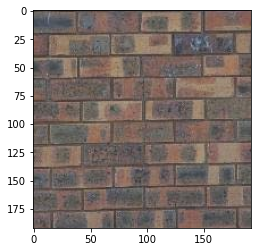

First:  34  Second:  66


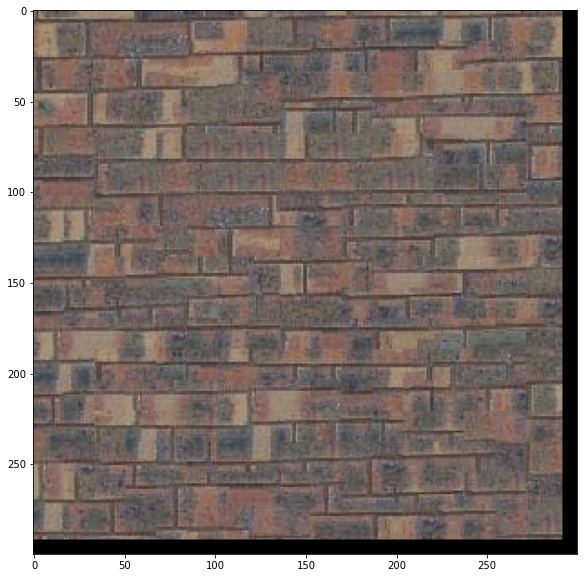

In [156]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 20
overlap = 3
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [6]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """

    image = np.zeros((out_size,out_size,3))
    
    random_ints = np.random.randint(len(sample)-patch_size, size=2)
    random_x = np.random.randint(0, sample.shape[0] - patch_size, 1)[0]
    random_y = np.random.randint(0, sample.shape[1] - patch_size, 1)[0]
    image[0:patch_size,0:patch_size] = sample[random_x:random_x+patch_size,random_y:random_y+patch_size]
    print("First: ", random_x, " Second: ", random_y)
    
    maskTop = np.zeros((patch_size, patch_size))
    maskLeftTop = np.zeros((patch_size, patch_size))
    maskLeft = np.zeros((patch_size, patch_size))
    maskLeft[:, 0:overlap] = 1
    maskLeftTop[:, 0:overlap] = 1
    maskTop[0:overlap, :] = 1
    maskLeftTop[0:overlap, :] = 1
    
    overlapFlag = 1
    ssdFlag = 1
    horizontalFlag = 1
    verticalFlag = 1
    combinedFlag = 1
    
    i = 0
    j = patch_size - overlap
    diff = j
    while i + patch_size < out_size:
        while j + patch_size < out_size:
            mask = None
            cutleftMask = np.zeros((patch_size,patch_size, 3))
            cuttopMask = np.zeros((patch_size,patch_size, 3))
            cutfinalMask = np.zeros((patch_size, patch_size, 3))
            if i >= diff and j >= diff:
                mask = maskLeftTop
            elif j >= diff:
                mask = maskLeft
            elif i >= diff:
                mask = maskTop
                
            leftMask = np.zeros((patch_size,patch_size, 3))
            topMask = np.zeros((patch_size,patch_size, 3))
            finalMask = np.zeros((patch_size, patch_size, 3))

            template = image[i:i+patch_size,j:j+patch_size]
            ssd = ssd_patch(template, mask, sample, patch_size)
            x, y = choose_sample(ssd, tol, patch_size)
            fit_patch = sample[x:x+patch_size, y:y+patch_size, :]
            
            bnd_cost = (fit_patch[:, :, 0] - template[:, :, 0])**2 + (fit_patch[:, :, 1] - template[:, :, 1])**2 + (fit_patch[:, :, 2] - template[:, :, 2])**2

            if i >= diff and j>= diff:
                leftMask[:, :, 0] = cut(bnd_cost.T).T
                leftMask[:, :, 1] = leftMask[:, :, 0]
                leftMask[:, :, 2] = leftMask[:, :, 0]
                topMask[:, :, 0] = cut(bnd_cost)
                topMask[:, :, 1] = topMask[:, :, 0]
                topMask[:, :, 2] = topMask[:, :, 0]
                finalMask = np.logical_and(leftMask, topMask)
                if combinedFlag == 1:
                    plt.figure("Combined Mask")
                    plt.imshow(finalMask.astype(np.float64))
                    plt.show()
                    combinedFlag = 0
            elif j >= diff:
                finalMask[:, :, 0] = cut(bnd_cost.T).T
                finalMask[:, :, 1] = finalMask[:, :, 0]
                finalMask[:, :, 2] = finalMask[:, :, 0]
                if verticalFlag == 1:
                    plt.figure("Vertical Mask")
                    plt.imshow(finalMask)
                    plt.show()
                    verticalFlag = 0
            elif i >= diff:
                finalMask[:, :, 0] = cut(bnd_cost)
                finalMask[:, :, 1] = finalMask[:, :, 0]
                finalMask[:, :, 2] = finalMask[:, :, 0]
                if horizontalFlag == 1:
                    plt.figure("Horizontal Mask")
                    plt.imshow(finalMask)
                    plt.show()
                    horizontalFlag = 0
            
            if overlapFlag == 1:
                plt.figure("Overlap")
                plt.imshow(template/255)
                plt.show()
                overlapFlag = 0
            
            if ssdFlag == 1:
                plt.figure("Fit patch")
                plt.imshow(ssd)
                plt.show()
                ssdFlag = 0
                
            
                
                
            image[i:i+patch_size, j:j+patch_size, :] = (1-finalMask) * template + finalMask * fit_patch
            j += diff
        j = 0
        print("i: ", i)
        i += diff
    # Todo 
    return image/255


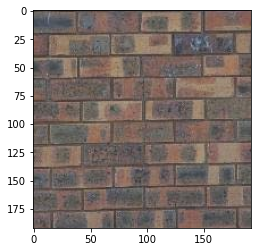

First:  114  Second:  120


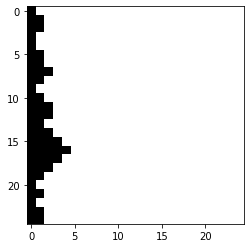

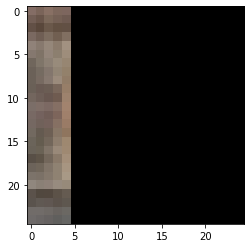

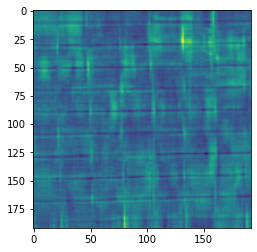

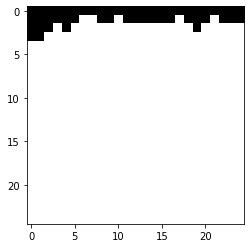

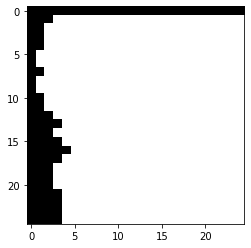

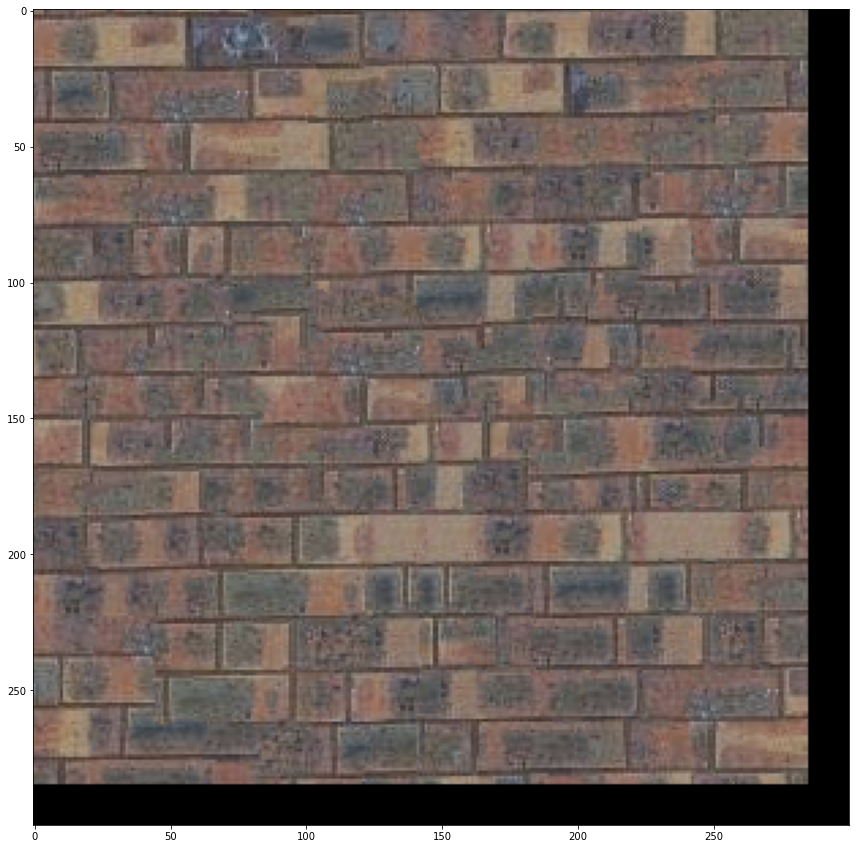

In [297]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 5
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

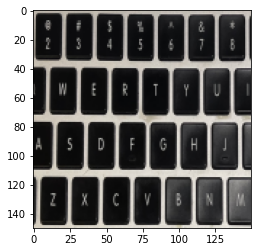

First:  28  Second:  71


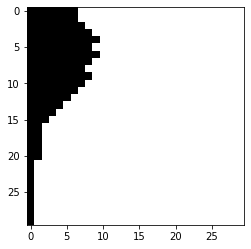

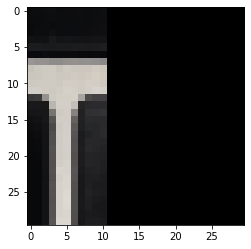

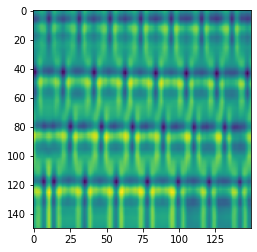

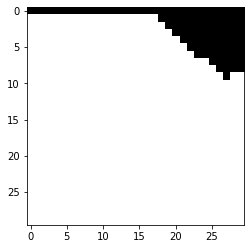

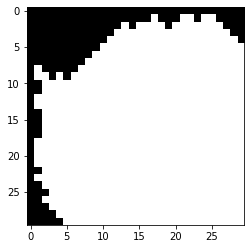

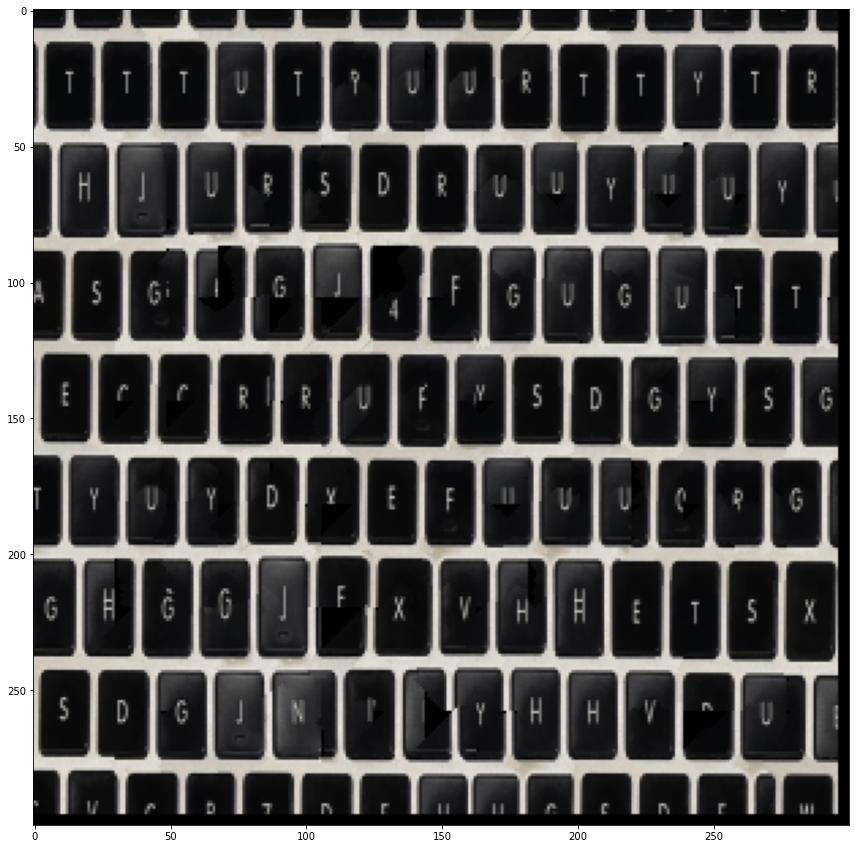

In [305]:
sample_img_fn = 'keyboard.JPG' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
g1, g2, g3 = cv2.split(sample_img)
t1 = cv2.resize(g1, (150, 150), interpolation = cv2.INTER_AREA)
t2 = cv2.resize(g2, (150, 150), interpolation = cv2.INTER_AREA)
t3 = cv2.resize(g3, (150, 150), interpolation = cv2.INTER_AREA)
sample_img = cv2.merge((t1, t2, t3))
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 30
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [272]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha, out_size):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    g1, g2, g3 = cv2.split(sample)
    t1 = cv2.resize(g1, (out_size, int(out_size*1.3)), interpolation = cv2.INTER_AREA)
    t2 = cv2.resize(g2, (out_size, int(out_size*1.3)), interpolation = cv2.INTER_AREA)
    t3 = cv2.resize(g3, (out_size, int(out_size*1.3)), interpolation = cv2.INTER_AREA)
    sample = cv2.merge((t1, t2, t3))
    
    s1, s2, s3 = cv2.split(guidance_im)
    st1 = cv2.resize(s1, (out_size, int(out_size*1.3)), interpolation = cv2.INTER_AREA)
    st2 = cv2.resize(s2, (out_size, int(out_size*1.3)), interpolation = cv2.INTER_AREA)
    st3 = cv2.resize(s3, (out_size, int(out_size*1.3)), interpolation = cv2.INTER_AREA)
    guidance_im = cv2.merge((st1, st2, st3))
    plt.figure()
    plt.imshow(sample)
    plt.figure()
    plt.imshow(guidance_im)
    plt.show()
    
    height = min(sample.shape[0], guidance_im.shape[0])
    width = min(sample.shape[1], guidance_im.shape[1])
    image = np.zeros((height, width, 3))
    
    random_ints = np.random.randint(len(sample)-patch_size, size=2)
    random_x = np.random.randint(0, sample.shape[0] - patch_size, 1)[0]
    random_y = np.random.randint(0, sample.shape[1] - patch_size, 1)[0]
    image[0:patch_size,0:patch_size] = sample[random_x:random_x+patch_size,random_y:random_y+patch_size]
    print("First: ", random_x, " Second: ", random_y)
    
    maskTop = np.zeros((patch_size, patch_size))
    maskLeftTop = np.zeros((patch_size, patch_size))
    maskLeft = np.zeros((patch_size, patch_size))
    maskLeft[:, 0:overlap] = 1
    maskLeftTop[:, 0:overlap] = 1
    maskTop[0:overlap, :] = 1
    maskLeftTop[0:overlap, :] = 1
    
    i = 0
    j = patch_size - overlap
    diff = j
    print("Height: ", height)
    print("Width: ", width)
    while i + patch_size < height:
        while j + patch_size < width:
            mask = None
            cutleftMask = np.zeros((patch_size,patch_size, 3))
            cuttopMask = np.zeros((patch_size,patch_size, 3))
            cutfinalMask = np.zeros((patch_size, patch_size, 3))
            if i >= diff and j >= diff:
                mask = maskLeftTop
            elif j >= diff:
                mask = maskLeft
            elif i >= diff:
                mask = maskTop
                
            leftMask = np.zeros((patch_size,patch_size, 3))
            topMask = np.zeros((patch_size,patch_size, 3))
            finalMask = np.zeros((patch_size, patch_size, 3))

            template = image[i:i+patch_size,j:j+patch_size]
#             print("Template shape: ", template.shape)
#             print("i: ", i, " j: ", j)
            if template.shape[0] != patch_size or template.shape[1] != patch_size:
                break
            
            ssd_template = ssd_patch(template,mask, sample, patch_size)
            guidance = guidance_im[i:i+patch_size, j:j+patch_size]
            ssd_guidance = ssd_patch(guidance,mask, sample, patch_size)
            ssd = alpha*ssd_guidance+(1-alpha)*ssd_template
            
            x, y = choose_sample(ssd, tol, patch_size)
            fit_patch = sample[x:x+patch_size, y:y+patch_size, :]
            
            bnd_cost = (fit_patch[:, :, 0] - template[:, :, 0])**2 + (fit_patch[:, :, 1] - template[:, :, 1])**2 + (fit_patch[:, :, 2] - template[:, :, 2])**2

            if i >= diff and j>= diff:
                leftMask[:, :, 0] = cut(bnd_cost.T).T
                leftMask[:, :, 1] = leftMask[:, :, 0]
                leftMask[:, :, 2] = leftMask[:, :, 0]
                topMask[:, :, 0] = cut(bnd_cost)
                topMask[:, :, 1] = topMask[:, :, 0]
                topMask[:, :, 2] = topMask[:, :, 0]
                finalMask = np.logical_and(leftMask, topMask)
            elif j >= diff:
                finalMask[:, :, 0] = cut(bnd_cost.T).T
                finalMask[:, :, 1] = finalMask[:, :, 0]
                finalMask[:, :, 2] = finalMask[:, :, 0]
            elif i >= diff:
                finalMask[:, :, 0] = cut(bnd_cost)
                finalMask[:, :, 1] = finalMask[:, :, 0]
                finalMask[:, :, 2] = finalMask[:, :, 0]
                
            image[i:i+patch_size, j:j+patch_size, :] = (1-finalMask) * template + finalMask * fit_patch
            j += diff
        print("i: ", i)
        j = 0
        i += diff
    # Todo 
    return image/255
    

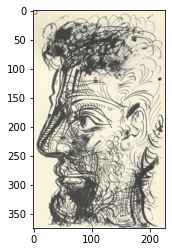

(375, 227, 3)


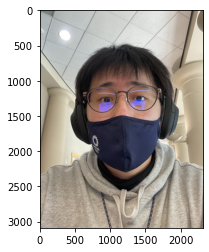

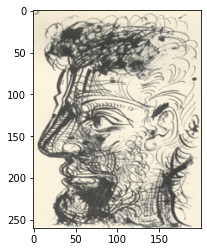

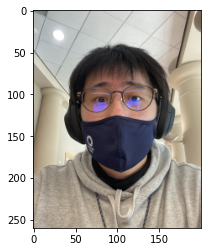

First:  154  Second:  71
Height:  260
Width:  200
i:  0
i:  5
i:  10
i:  15
i:  20
i:  25
i:  30
i:  35
i:  40
i:  45
i:  50
i:  55
i:  60
i:  65
i:  70
i:  75
i:  80
i:  85
i:  90
i:  95
i:  100
i:  105
i:  110
i:  115
i:  120
i:  125
i:  130
i:  135
i:  140
i:  145
i:  150
i:  155
i:  160
i:  165
i:  170
i:  175
i:  180
i:  185
i:  190
i:  195
i:  200
i:  205
i:  210
i:  215
i:  220
i:  225
i:  230
i:  235
i:  240
i:  245


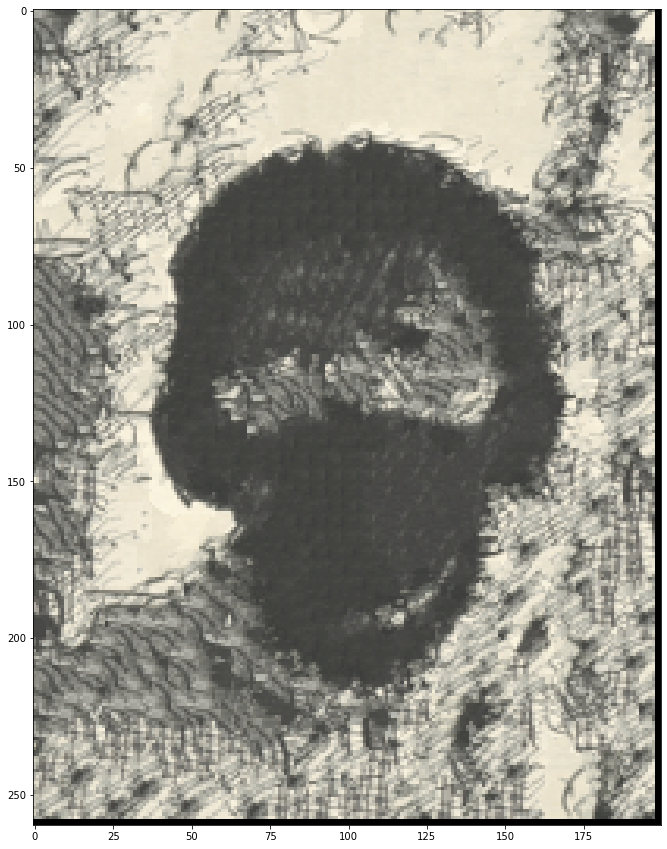

In [273]:
# load/process appropriate input texture and guidance images

texture_img_fn = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()
print(texture_img.shape)

guidance_img_fn = 'tommy.JPG'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()

patch_size = 13
overlap = 8
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha, 200)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

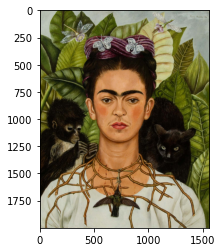

(2000, 1558, 3)


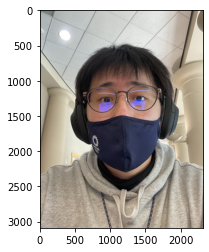

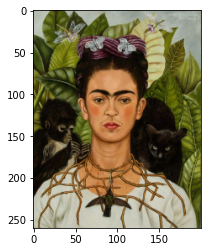

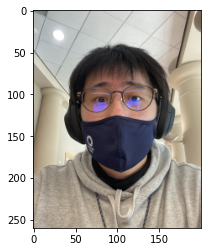

First:  176  Second:  5
Height:  260
Width:  200
i:  0
i:  5
i:  10
i:  15
i:  20
i:  25
i:  30
i:  35
i:  40
i:  45
i:  50
i:  55
i:  60
i:  65
i:  70
i:  75
i:  80
i:  85
i:  90
i:  95
i:  100
i:  105
i:  110
i:  115
i:  120
i:  125
i:  130
i:  135
i:  140
i:  145
i:  150
i:  155
i:  160
i:  165
i:  170
i:  175
i:  180
i:  185
i:  190
i:  195
i:  200
i:  205
i:  210
i:  215
i:  220
i:  225
i:  230
i:  235
i:  240
i:  245


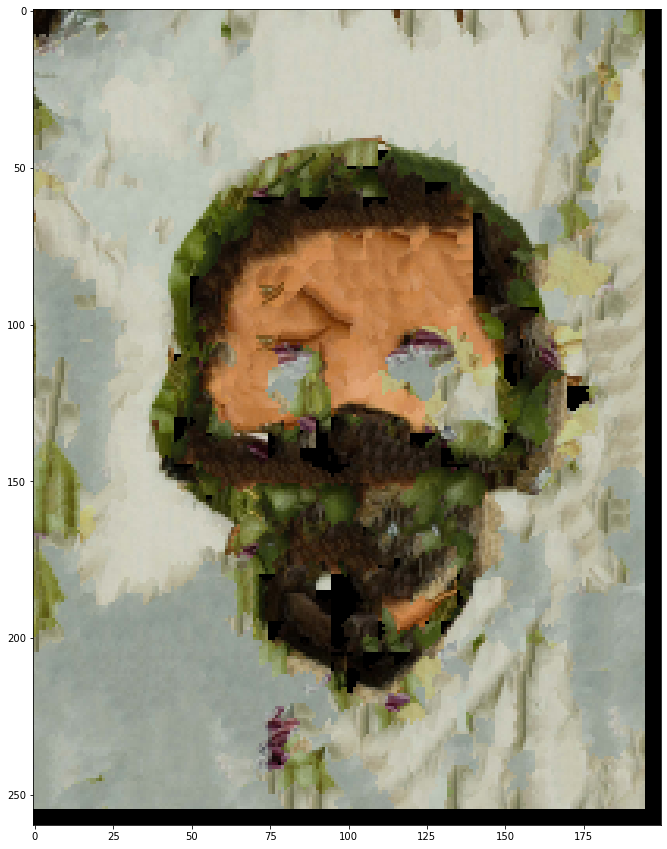

In [299]:
# load/process appropriate input texture and guidance images

texture_img_fn = 'samples/text_art.jpeg' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()
print(texture_img.shape)

guidance_img_fn = 'tommy.JPG'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()

patch_size = 10
overlap = 5
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha, 200)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()